# Building Neural Networks from Scratch with NumPy

This notebook demonstrates how to:
1. **Implement a feedforward neural network** (forward and backward pass) using **NumPy**.
2. **Train** the network on **spam detection** from the `NotShrirang/email-spam-filter` dataset, using **TF-IDF** for text.
3. **Experiment** with different batch sizes and learning rates.
4. **Illustrate** vanishing and exploding gradients in deeper networks.

**No Keras or TensorFlow** is used—it's all done with core Python/NumPy.


In [1]:
# Imports (No Keras/TensorFlow)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For reproducibility:
np.random.seed(42)

## 1. Activation and Loss Functions (NumPy)

We'll define some basic building blocks: `sigmoid`, `relu`, `softmax`, etc., plus a cross-entropy loss function.

In [2]:
def sigmoid(x):
    # clip to avoid overflow in large exponent
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    # numeric stability shift
    shifted = x - np.max(x, axis=1, keepdims=True)
    ex = np.exp(shifted)
    return ex / np.sum(ex, axis=1, keepdims=True)

def categorical_cross_entropy(y_true, y_pred):
    # clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]


## 2. Base Neural Network in NumPy

Implements forward/backward passes, He initialization, and can train via a simple loop. We'll do mini-batches inside a `.train(...)` method for basic gradient descent.


In [3]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activations):
        """
        layer_sizes: list (e.g. [input_dim, hidden_dim, ..., output_dim])
        activations: list of string names, e.g. ['relu','softmax'] (one per hidden/output layer)
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)

        # map from string to actual function
        self.activation_map = {
            'sigmoid': (sigmoid, sigmoid_derivative),
            'relu': (relu, relu_derivative),
            'softmax': (softmax, None),
            'tanh': (tanh, tanh_derivative)
        }

        self.activations = []
        self.activation_derivs = []
        for act in activations:
            f, d = self.activation_map[act]
            self.activations.append(f)
            self.activation_derivs.append(d)

        self.initialize_parameters()
        # placeholders for forward pass data
        self.Z = [None]*(self.num_layers-1)
        self.A = [None]*self.num_layers

    def initialize_parameters(self):
        # He initialization
        self.weights = []
        self.biases = []
        for i in range(1, self.num_layers):
            scale = np.sqrt(2.0 / self.layer_sizes[i-1])
            W = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * scale
            b = np.zeros((1, self.layer_sizes[i]))
            self.weights.append(W)
            self.biases.append(b)

    def forward_propagation(self, X):
        self.A[0] = X
        for i in range(self.num_layers-1):
            self.Z[i] = np.dot(self.A[i], self.weights[i]) + self.biases[i]
            self.A[i+1] = self.activations[i](self.Z[i])
        return self.A[-1]

    def compute_loss(self, y_true, y_pred):
        return categorical_cross_entropy(y_true, y_pred)

    def backward_propagation(self, y_true):
        m = y_true.shape[0]
        dW = [None]*(self.num_layers-1)
        db = [None]*(self.num_layers-1)

        # handle last layer
        if self.activations[-1] == softmax:
            dZ = self.A[-1] - y_true  # (y_pred - y_true)
        else:
            # e.g. sigmoid + cross-entropy
            dA = -(y_true / self.A[-1] - (1 - y_true)/(1 - self.A[-1]))
            dZ = dA * self.activation_derivs[-1](self.Z[-1])

        dW[-1] = np.dot(self.A[-2].T, dZ)/m
        db[-1] = np.sum(dZ, axis=0, keepdims=True)/m

        for l in range(self.num_layers-3, -1, -1):
            dA = np.dot(dZ, self.weights[l+1].T)
            dZ = dA * self.activation_derivs[l](self.Z[l])
            dW[l] = np.dot(self.A[l].T, dZ)/m
            db[l] = np.sum(dZ, axis=0, keepdims=True)/m

        return {'dW': dW, 'db': db}

    def update_parameters(self, grads, lr):
        dW = grads['dW']
        db = grads['db']
        for i in range(self.num_layers-1):
            self.weights[i] -= lr * dW[i]
            self.biases[i] -= lr * db[i]

    def train_step(self, X_batch, y_batch, lr):
        y_pred = self.forward_propagation(X_batch)
        loss = self.compute_loss(y_batch, y_pred)
        grads = self.backward_propagation(y_batch)
        self.update_parameters(grads, lr)
        return loss

    def train(self, X_train, y_train, X_val=None, y_val=None, batch_size=32, learning_rate=0.01,
              epochs=10, verbose=True, record_every=1):
        m = X_train.shape[0]
        history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

        for epoch in range(epochs):
            perm = np.random.permutation(m)
            X_shuf = X_train[perm]
            y_shuf = y_train[perm]

            epoch_loss = 0
            num_batches = int(np.ceil(m/batch_size))
            for i in range(num_batches):
                start = i*batch_size
                end = min((i+1)*batch_size, m)
                X_batch = X_shuf[start:end]
                y_batch = y_shuf[start:end]
                b_loss = self.train_step(X_batch, y_batch, learning_rate)
                epoch_loss += b_loss * (end - start)
            epoch_loss /= m

            # track train/val if needed
            if epoch % record_every == 0 or epoch == epochs-1:
                y_pred_train = self.predict(X_train)
                train_acc = np.mean(np.argmax(y_pred_train, axis=1) == np.argmax(y_train, axis=1))
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(train_acc)

                if X_val is not None and y_val is not None:
                    y_pred_val = self.predict(X_val)
                    val_loss = self.compute_loss(y_val, y_pred_val)
                    val_acc  = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_val, axis=1))
                    history['val_loss'].append(val_loss)
                    history['val_acc'].append(val_acc)
                    if verbose:
                        print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
                else:
                    if verbose:
                        print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f} - acc: {train_acc:.4f}")
        return history

    def predict(self, X):
        return self.forward_propagation(X)


### Quick XOR Check
We confirm that the above network can learn XOR with a small architecture.

XOR Accuracy: 1.0


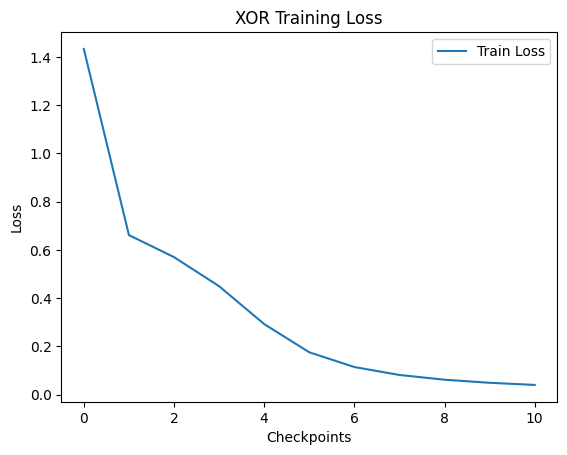

In [4]:
# XOR dataset: 2 inputs -> 2 classes, one-hot.
X_xor = np.array([[0,0],[0,1],[1,0],[1,1]])
y_xor = np.array([[1,0],[0,1],[0,1],[1,0]])

# define net
xor_net = NeuralNetwork(
    layer_sizes=[2,4,2],
    activations=['sigmoid','sigmoid']
)

hist_xor = xor_net.train(
    X_xor,
    y_xor,
    batch_size=4,  # full batch
    learning_rate=0.5,
    epochs=1000,
    verbose=False,
    record_every=100
)

# Evaluate
y_out = xor_net.predict(X_xor)
pred_cls = np.argmax(y_out, axis=1)
true_cls = np.argmax(y_xor, axis=1)
acc = np.mean(pred_cls==true_cls)
print("XOR Accuracy:", acc)

plt.plot(hist_xor['train_loss'], label='Train Loss')
plt.title('XOR Training Loss')
plt.xlabel('Checkpoints')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3. Spam Detection (NumPy)

We will:
1. Load `NotShrirang/email-spam-filter`
2. Split train/dev/test
3. TF-IDF vectorize
4. Convert labels to one-hot for a 2-output softmax
5. Train a `[2000 -> 64 -> 2]` network for ~10 epochs.


In [5]:
spam_data = load_dataset("NotShrirang/email-spam-filter")
df = spam_data['train'].to_pandas()
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


### 3.1 Split into Train/Dev/Test, TF-IDF, and One-Hot

In [6]:
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label_num'], random_state=42)
train_df, dev_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label_num'], random_state=42)

print(len(train_df), len(dev_df), len(test_df))

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X_train_tfidf = vectorizer.fit_transform(train_df['text']).toarray()
y_train_nums = train_df['label_num'].values

X_dev_tfidf = vectorizer.transform(dev_df['text']).toarray()
y_dev_nums = dev_df['label_num'].values

X_test_tfidf = vectorizer.transform(test_df['text']).toarray()
y_test_nums = test_df['label_num'].values

def to_one_hot(lbls, num_classes=2):
    return np.eye(num_classes)[lbls]

y_train_oh = to_one_hot(y_train_nums, 2)
y_dev_oh   = to_one_hot(y_dev_nums, 2)
y_test_oh  = to_one_hot(y_test_nums, 2)


3308 828 1035


### 3.2 Build a `[2000->64->2]` Net with ReLU + Softmax
Train for 10 epochs and check the test accuracy.

Epoch 1/50 - loss: 0.5815 - acc: 0.7101 - val_loss: 0.5329 - val_acc: 0.7101
Epoch 2/50 - loss: 0.4722 - acc: 0.7443 - val_loss: 0.4096 - val_acc: 0.7403
Epoch 3/50 - loss: 0.3412 - acc: 0.9531 - val_loss: 0.2936 - val_acc: 0.9300
Epoch 4/50 - loss: 0.2433 - acc: 0.9628 - val_loss: 0.2230 - val_acc: 0.9372
Epoch 5/50 - loss: 0.1849 - acc: 0.9680 - val_loss: 0.1820 - val_acc: 0.9589
Epoch 6/50 - loss: 0.1487 - acc: 0.9743 - val_loss: 0.1527 - val_acc: 0.9614
Epoch 7/50 - loss: 0.1242 - acc: 0.9831 - val_loss: 0.1363 - val_acc: 0.9626
Epoch 8/50 - loss: 0.1056 - acc: 0.9840 - val_loss: 0.1183 - val_acc: 0.9686
Epoch 9/50 - loss: 0.0925 - acc: 0.9876 - val_loss: 0.1064 - val_acc: 0.9698
Epoch 10/50 - loss: 0.0814 - acc: 0.9897 - val_loss: 0.0991 - val_acc: 0.9722
Epoch 11/50 - loss: 0.0720 - acc: 0.9909 - val_loss: 0.0947 - val_acc: 0.9734
Epoch 12/50 - loss: 0.0658 - acc: 0.9915 - val_loss: 0.0857 - val_acc: 0.9771
Epoch 13/50 - loss: 0.0595 - acc: 0.9921 - val_loss: 0.0867 - val_acc: 0.

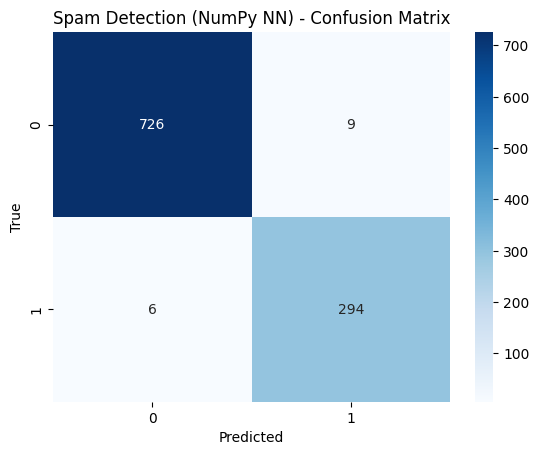

In [7]:
spam_net_np = NeuralNetwork(
    layer_sizes=[2000,64,2],
    activations=['relu','softmax']
)

hist_spam_np = spam_net_np.train(
    X_train_tfidf, y_train_oh,
    X_dev_tfidf,   y_dev_oh,
    batch_size=64,
    learning_rate=0.2,
    epochs=50,
    verbose=True,
    record_every=1
)

y_test_pred_proba_np = spam_net_np.predict(X_test_tfidf)
y_test_pred_class_np = np.argmax(y_test_pred_proba_np, axis=1)
test_acc_np = np.mean(y_test_pred_class_np == y_test_nums)
print(f"\nNumPy Network Test Accuracy: {test_acc_np:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_nums, y_test_pred_class_np))

cm = confusion_matrix(y_test_nums, y_test_pred_class_np)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Spam Detection (NumPy NN) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Quite impressive ! 98.5% accuracy !! Which is much more than the 50% of the baseline and what we created in previous session with baseline. 

### 3.3 Plot the Training/Dev Loss

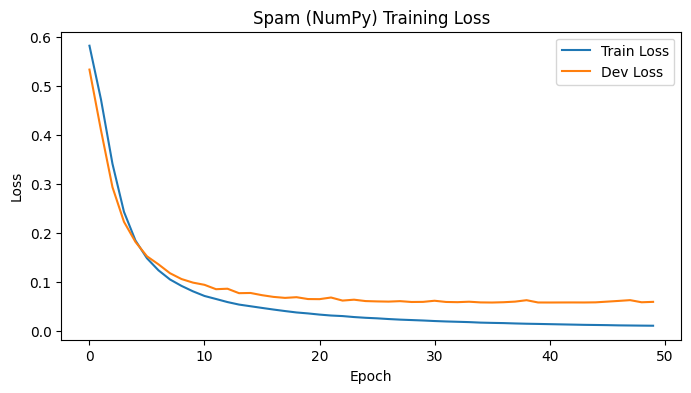

In [8]:
plt.figure(figsize=(8,4))
plt.plot(hist_spam_np['train_loss'], label='Train Loss')
if len(hist_spam_np['val_loss'])>0:
    plt.plot(hist_spam_np['val_loss'], label='Dev Loss')
plt.title('Spam (NumPy) Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Nevertheless, we see the dev loss starting to increase after 20 epochs. Which means we most likely overfit the training data past that point. To avoid this, we could have used early stopping or regularization. 

## 4. Different Batch Sizes and Learning Rates on Spam Data (NumPy)
We'll define a short experiment, training for a small number of epochs, just to illustrate how the training loss changes across `(batch_size, learning_rate)` combos.

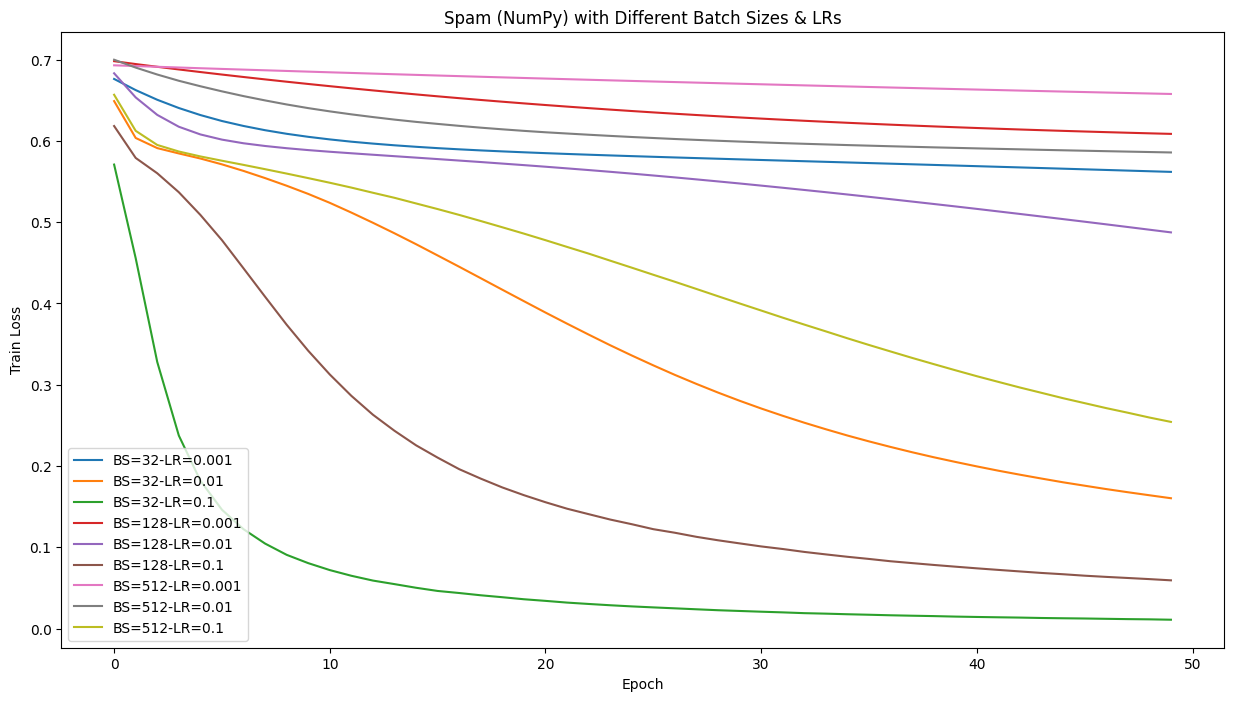

In [9]:
batch_sizes = [32, 128, 512]
lrs = [0.001, 0.01, 0.1]

results = {}

for bs in batch_sizes:
    for lr in lrs:
        key = f"BS={bs}-LR={lr}"
        net_temp = NeuralNetwork(
            layer_sizes=[2000,32,2],
            activations=['relu','softmax']
        )
        hist_temp = net_temp.train(
            X_train_tfidf, y_train_oh,
            X_dev_tfidf,   y_dev_oh,
            batch_size=bs,
            learning_rate=lr,
            epochs=50,
            verbose=False,
            record_every=1
        )
        results[key] = hist_temp

# Plot the training loss curves
plt.figure(figsize=(15,8))
for key, hist_ in results.items():
    plt.plot(hist_['train_loss'], label=key)
plt.title('Spam (NumPy) with Different Batch Sizes & LRs')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

You can see the differences in loss curves for different batch sizes and learning rates. Generally with really low learning rates the curves are quite flat and the loss is high. And at equal learning rates, the lower batch sizes converge faster.

## 5. Vanishing and Exploding Gradients

We'll build deeper networks in NumPy. By controlling:
- **Small init** or `sigmoid` for **vanishing**
- **Large init** or large LR for **exploding**
We'll track the **gradient norm** at each epoch to see the pattern.

In [10]:
def gradient_norm(nn, X_batch, y_batch):
    _ = nn.forward_propagation(X_batch)
    grads = nn.backward_propagation(y_batch)
    total_sq = 0
    for dw, db in zip(grads['dW'], grads['db']):
        total_sq += np.sum(dw**2) + np.sum(db**2)
    return np.sqrt(total_sq)

def train_with_grad_tracking(nn, X, y, epochs=20, batch_size=32, lr=0.01):
    m = X.shape[0]
    grad_norms = []
    losses = []

    for e in range(epochs):
        perm = np.random.permutation(m)
        X_shuf = X[perm]
        y_shuf = y[perm]
        epoch_loss = 0
        num_batches = int(np.ceil(m/batch_size))

        for i in range(num_batches):
            start = i*batch_size
            end = min((i+1)*batch_size, m)
            X_batch = X_shuf[start:end]
            y_batch = y_shuf[start:end]

            # measure gradient norm before update (arbitrary choice)
            gn = gradient_norm(nn, X_batch, y_batch)
            grad_norms.append(gn)

            b_loss = nn.train_step(X_batch, y_batch, lr)
            epoch_loss += b_loss*(end-start)

        epoch_loss /= m
        losses.append(epoch_loss)

    return grad_norms, losses

# We'll create artificial data for demonstration
# E.g. 500 samples, dimension=20, 5-output classification
N = 500
D = 20
C = 5

X_demo = np.random.randn(N, D)
y_demo_lbls = np.random.randint(0,C,size=(N,))
y_demo_oh   = np.eye(C)[y_demo_lbls]

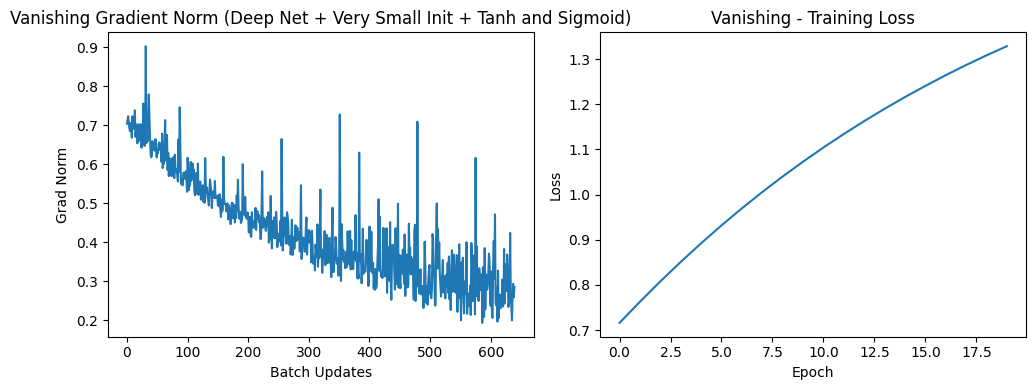

In [11]:
# 5.1 Vanishing Gradient Example

class SmallInitNet(NeuralNetwork):
    def initialize_parameters(self):
        # Extremely small init => prone to vanishing
        self.weights = []
        self.biases = []
        for i in range(1, self.num_layers):
            W = np.random.normal(0, 1e-2, (self.layer_sizes[i-1], self.layer_sizes[i]))
            b = np.zeros((1, self.layer_sizes[i]))
            self.weights.append(W)
            self.biases.append(b)

# All 'sigmoid' => more saturation => easier vanishing
vanish_net = SmallInitNet(
    layer_sizes=[20, 64, 64, 5],
    activations=['tanh','tanh','sigmoid','sigmoid']
)


gn_vanish, loss_vanish = train_with_grad_tracking(
    vanish_net,
    X_demo,     # e.g. a random or real dataset of shape (N, 20)
    y_demo_oh,  # e.g. one-hot labels of shape (N, 5)
    epochs=20,
    batch_size=16,
    lr=0.01
)

plt.figure(figsize=(10,4))

# Left: gradient norm curve
plt.subplot(1,2,1)
plt.plot(gn_vanish)
plt.title('Vanishing Gradient Norm (Deep Net + Very Small Init + Tanh and Sigmoid)')
plt.xlabel('Batch Updates')
plt.ylabel('Grad Norm')

# Right: training loss curve
plt.subplot(1,2,2)
plt.plot(loss_vanish)
plt.title('Vanishing - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


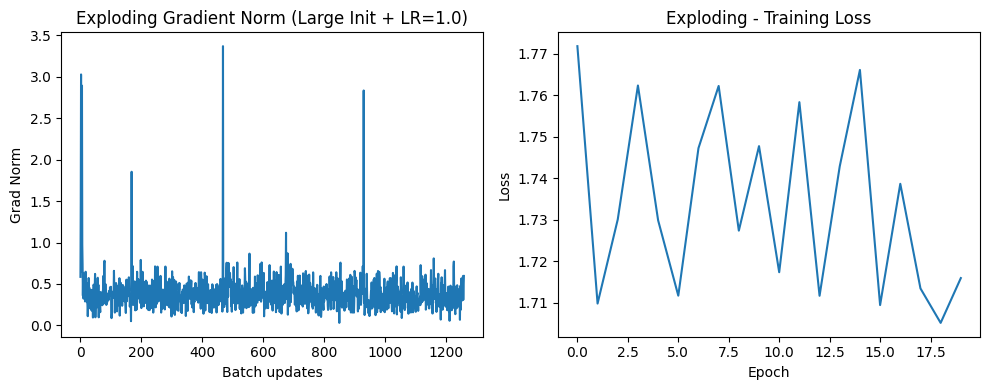

In [12]:
# 5.2 Exploding Gradient Example
class LargeInitNet(NeuralNetwork):
    def initialize_parameters(self):
        self.weights = []
        self.biases = []
        for i in range(1, self.num_layers):
            W = np.random.normal(0, 1e-1, (self.layer_sizes[i-1], self.layer_sizes[i]))
            b = np.zeros((1, self.layer_sizes[i]))
            self.weights.append(W)
            self.biases.append(b)

explode_net = LargeInitNet(
    layer_sizes=[20,64,64,64,5],
    activations=['relu','relu','relu','softmax']
)

gn_explode, loss_explode = train_with_grad_tracking(
    explode_net,
    X_demo, y_demo_oh,
    epochs=20,
    batch_size=8,
    lr=3.0  # intentionally large
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(gn_explode)
plt.title('Exploding Gradient Norm (Large Init + LR=1.0)')
plt.xlabel('Batch updates')
plt.ylabel('Grad Norm')

plt.subplot(1,2,2)
plt.plot(loss_explode)
plt.title('Exploding - Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


### Observing the Norm Plots
- **Vanishing**: the gradient norm typically goes near 0, leading to minimal changes in weights.
- **Exploding**: the gradient norm can skyrocket (sometimes NaN), and training becomes unstable.

## Conclusion
We've built a neural network with pure **NumPy**:
- It handles feedforward/backprop.
- We tested it on **XOR**.
- We applied it to **spam detection** using TF-IDF.
- We tried **different batch sizes** and **learning rates**.
- We **demonstrated** vanishing/exploding gradients by tracking gradient norms in a deeper net.

This clarifies many core concepts that frameworks like PyTorch or TensorFlow manage under the hood.